# Training Example
In this notebook I will give an example of how to train a new model on surfaceline and characteristcpoints data. 
This notebook is how the supplied model was trained as well.

# Loading data
First we point the preprocessor to the folders containing the filepairs, some are in the format where the pair is always called `surfacelines.csv` and `characteristicpoints.csv` (default) and others are in the format where the names are different but then endings are always `<name>.csv` and `<name>.krp.csv`.

We will holdout a few files from the training to test on later, these files will also not be used as validation during the training. You can of course omit this step and just use everything

In [67]:
from sklearn.model_selection import train_test_split
from dijkprofile_annotator.preprocessing import get_file_pairs_from_dir

path_primair_fryslan = "/home/parting/repositories/dijkprofile-annotator/data/raw_immutable/fryslan/Toetsing Primaire Keringen ronde 1"
path_regional_fryslan = "/home/parting/repositories/dijkprofile-annotator/data/raw_immutable/fryslan/Toetsing Regionale Keringen ronde 1"
path_regional_fryslan_2 = "/home/parting/repositories/dijkprofile-annotator/data/raw_immutable/fryslan/Toetsing Regionale Keringen ronde 2"
path_primair_hhnk = "/home/parting/repositories/dijkprofile-annotator/data/raw_immutable/hhnk"
path_primair_wsvv = "/home/parting/repositories/dijkprofile-annotator/data/raw_immutable/wsvv"

# hold out some random files that are also not used as validation during training
pairs = [*get_file_pairs_from_dir(path_primair_hhnk), *get_file_pairs_from_dir(path_primair_fryslan), *get_file_pairs_from_dir(path_primair_wsvv, krp_format=True)]
print(f"found {len(pairs)} labeled profile files")
pairs, pairs_holdout = train_test_split(pairs, shuffle=True, test_size=0.05)

print(f"using {len(pairs)} labeled profile files for training")
print(f"using {len(pairs_holdout)} labeled profile files as holdout")

found 47 labeled profile files
using 44 labeled profile files for training
using 3 labeled profile files as holdout


# parameters
## class mapping
Choose the type of model you would like to train. The more complex class mappings have additional features but those might not work as well as the simple ones.
The options are:
- `simple` only the dijk
- `sloot` dijk and sloot
- `berm` dijk, slot and berm
- `full` everything that is in the characteristicpoints file.

## profile size
The profiles vary in length, a fixed window size is used to the profile in, the profile size is the cutoff after which the model won't see any more of the profile. A small size might miss the dijk section of the profile, but a very large profile leaves a lot of empty space on the right. 512 is a reasonable size that captures most if not all profiles

## filter missing
Use this parameter to turn on or off filtering of incomplete profiles
The model can take profiles that don't have every desired point labeled as input, but this might hinder training as the samples are more confusing for the model. For the more comples class mappings though, very few examples are left if only the complete ones are used. I would always turn this on for the `simple` class mapping

In [68]:
class_mapping = 'simple'
max_profile_size = 512
filter_missing = True

# load holdout data and inspect some profiles

In [69]:
# load the holdout set to memory to inspect some of the profiles, the other pairs will be read during training

from dijkprofile_annotator.preprocessing import file_pairs_to_tensor_profiles

profile_dict_holdout = file_pairs_to_tensor_profiles(pairs_holdout, max_profile_size, class_mapping, filter_missing)
print(f"found {len(profile_dict_holdout)} labeled profiles in holdout")

found 1048 labeled profiles in holdout


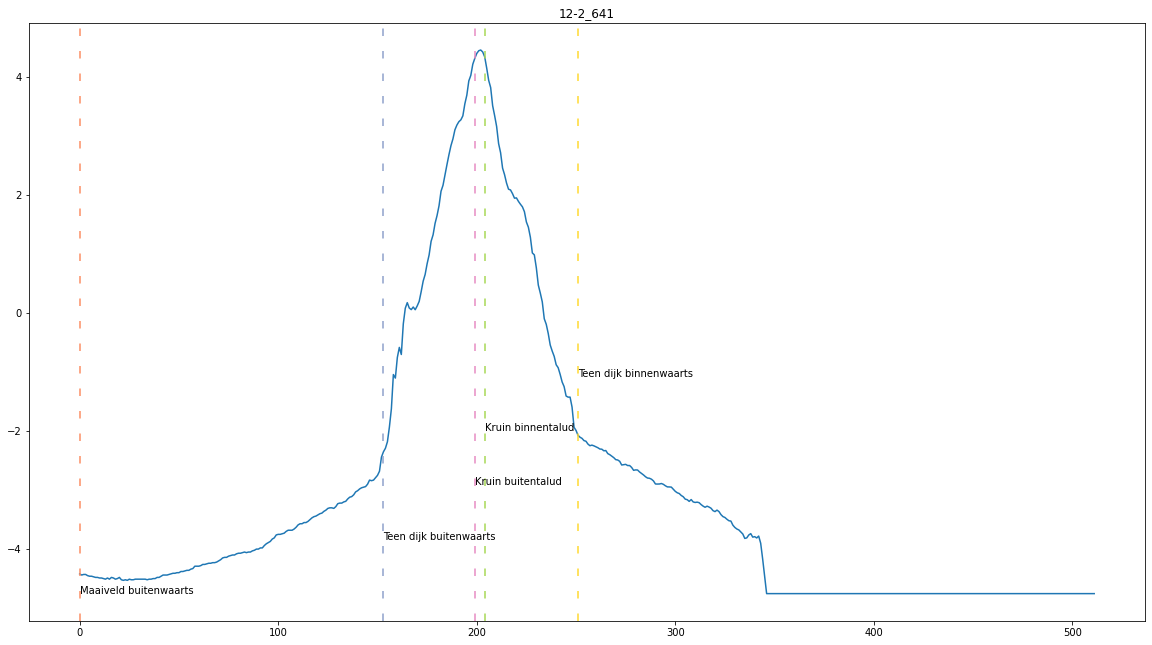

In [70]:
# plot some profiles and the labels, run this multiple times to inspect some of the labels

from dijkprofile_annotator import visualize_sample
import random
random_key = random.choice(list(profile_dict_holdout.keys()))

random_profile = profile_dict_holdout[random_key]

visualize_sample(random_profile['profile'], random_profile['label'], random_key, class_mapping)

# training
Now lets train the model on the loaded data and save it.
Adjust the batch sizes if you get out of memory errors. adjust epochs if the training hasnt converged yet.

In [71]:
import dijkprofile_annotator.training as training
import datetime
import torch

epochs = 30
batch_size_train = 32
batch_size_val = 512
test_size = 0.2

# train model
model = training.train(pairs,
                       epochs=epochs,  
                       batch_size_train=batch_size_train,
                       batch_size_val=batch_size_val,
                       max_profile_size=max_profile_size,
                       class_list=class_mapping,
                       test_size=test_size
                      )

# save model with timestamp in case you do multiple runs
now = datetime.datetime.now()
timestamp = now.strftime('%Y-%m-%dT%H:%M')

model_path = f"../output/models/dijknet_{timestamp}.pt"

# save model
torch.save(model.state_dict(), model_path)

loading datasets
scaler in dataset class is depracated and moved to preprocessing
scaler in dataset class is depracated and moved to preprocessing
loaded datasets:
    train: 2951 samples
    test:  738 samples
constructing model with 6 output classes
starting training.
epoch: 0


100%|██████████| 93/93 [00:08<00:00, 11.61it/s]

training loss:  1.463534


validation accuracy: 0.6929338843421599
validation accuracy isotonic regression: 0.6766311004098537
validation loss: 1.0759339332580566
epoch: 1


100%|██████████| 93/93 [00:07<00:00, 11.64it/s]

training loss:  1.0069642


validation accuracy: 0.7257206840852721
validation accuracy isotonic regression: 0.7033591650228586
validation loss: 0.8877151608467102
epoch: 2


100%|██████████| 93/93 [00:08<00:00, 11.60it/s]

training loss:  0.7540508


validation accuracy: 0.8741187205356834
validation accuracy isotonic regression: 0.8226291690252523
validation loss: 0.47423499822616577
epoch: 3


100%|██████████| 93/93 [00:08<00:00, 11.57it/s]

training loss:  0.40000236


validation accuracy: 0.9302011000371613
validation accuracy isotonic regression: 0.9088776343691666
validation loss: 0.294253408908844
epoch: 4


100%|██████████| 93/93 [00:07<00:00, 11.63it/s]

training loss:  0.33659142


validation accuracy: 0.9243845475458465
validation accuracy isotonic regression: 0.909572550680785
validation loss: 0.306395024061203
epoch: 5


100%|██████████| 93/93 [00:08<00:00, 11.52it/s]

training loss:  0.29312882


validation accuracy: 0.941366465745774
validation accuracy isotonic regression: 0.938337680512825
validation loss: 0.22903095185756683
epoch: 6


100%|██████████| 93/93 [00:08<00:00, 11.56it/s]

training loss:  0.25427133


validation accuracy: 0.9487233119728291
validation accuracy isotonic regression: 0.9456720942944552
validation loss: 0.21038717031478882
epoch: 7


100%|██████████| 93/93 [00:06<00:00, 14.41it/s]

training loss:  0.20649947


validation accuracy: 0.9488166539014968
validation accuracy isotonic regression: 0.9470507528929584
validation loss: 0.19252389669418335
epoch: 8


100%|██████████| 93/93 [00:07<00:00, 13.21it/s]

training loss:  0.20037796


validation accuracy: 0.9554023236300038
validation accuracy isotonic regression: 0.951554627545112
validation loss: 0.17498762905597687
epoch: 9


100%|██████████| 93/93 [00:06<00:00, 13.47it/s]

training loss:  0.18509579


validation accuracy: 0.9470106985716693
validation accuracy isotonic regression: 0.9417632280197819
validation loss: 0.18510974943637848
epoch: 10


100%|██████████| 93/93 [00:06<00:00, 13.89it/s]

training loss:  0.21380462


validation accuracy: 0.9198160424696661
validation accuracy isotonic regression: 0.8590150681217159
validation loss: 0.2946850657463074
epoch: 11


100%|██████████| 93/93 [00:06<00:00, 14.07it/s]

training loss:  0.29398552


validation accuracy: 0.9300138085289339
validation accuracy isotonic regression: 0.9028782633553565
validation loss: 0.2666456699371338
epoch: 12


100%|██████████| 93/93 [00:06<00:00, 14.06it/s]

training loss:  0.2303996


validation accuracy: 0.9442293285268598
validation accuracy isotonic regression: 0.9377471788794594
validation loss: 0.20077601075172424
epoch: 13


100%|██████████| 93/93 [00:06<00:00, 14.63it/s]

training loss:  0.18879372


validation accuracy: 0.9508609096560858
validation accuracy isotonic regression: 0.9444041125542295
validation loss: 0.1738210916519165
epoch: 14


100%|██████████| 93/93 [00:06<00:00, 14.73it/s]

training loss:  0.17899714


validation accuracy: 0.9543127043057331
validation accuracy isotonic regression: 0.9510298703624084
validation loss: 0.16828122735023499
epoch: 15


100%|██████████| 93/93 [00:07<00:00, 12.89it/s]

training loss:  0.16333811


validation accuracy: 0.9582951976134714
validation accuracy isotonic regression: 0.9568370211440905
validation loss: 0.14842432737350464
epoch: 16


100%|██████████| 93/93 [00:07<00:00, 13.03it/s]

training loss:  0.16671431


validation accuracy: 0.9593799894889898
validation accuracy isotonic regression: 0.9573635506418954
validation loss: 0.15164342522621155
epoch: 17


100%|██████████| 93/93 [00:07<00:00, 12.90it/s]

training loss:  0.16754928


validation accuracy: 0.9538062948041257
validation accuracy isotonic regression: 0.951110417863964
validation loss: 0.1690748631954193
epoch: 18


100%|██████████| 93/93 [00:06<00:00, 13.31it/s]

training loss:  0.19742721


validation accuracy: 0.9556302602312206
validation accuracy isotonic regression: 0.9470599858106765
validation loss: 0.15575554966926575
epoch: 19


100%|██████████| 93/93 [00:07<00:00, 13.02it/s]

training loss:  0.16796021


validation accuracy: 0.9620878000175004
validation accuracy isotonic regression: 0.955860863744685
validation loss: 0.1488332450389862
epoch: 20


100%|██████████| 93/93 [00:06<00:00, 14.06it/s]

training loss:  0.16584931


validation accuracy: 0.9600212637302095
validation accuracy isotonic regression: 0.9584418609079006
validation loss: 0.1508440375328064
epoch: 21


100%|██████████| 93/93 [00:06<00:00, 13.69it/s]

training loss:  0.15867987


validation accuracy: 0.9530205346841727
validation accuracy isotonic regression: 0.9528408050537109
validation loss: 0.16721205413341522
epoch: 22


100%|██████████| 93/93 [00:07<00:00, 13.10it/s]

training loss:  0.15028384


validation accuracy: 0.9625009688655888
validation accuracy isotonic regression: 0.9609312040615925
validation loss: 0.14148670434951782
epoch: 23


100%|██████████| 93/93 [00:06<00:00, 13.71it/s]

training loss:  0.13669953


validation accuracy: 0.9619199870961957
validation accuracy isotonic regression: 0.9581511674729069
validation loss: 0.14070254564285278
epoch: 24


100%|██████████| 93/93 [00:06<00:00, 13.71it/s]

training loss:  0.14649372


validation accuracy: 0.9601324132058473
validation accuracy isotonic regression: 0.9574797132373911
validation loss: 0.14424684643745422
epoch: 25


100%|██████████| 93/93 [00:06<00:00, 13.56it/s]

training loss:  0.14183207


validation accuracy: 0.9609809807971516
validation accuracy isotonic regression: 0.9560039992881032
validation loss: 0.13563746213912964
epoch: 26


100%|██████████| 93/93 [00:07<00:00, 12.79it/s]

training loss:  0.13567778


validation accuracy: 0.9631733008190594
validation accuracy isotonic regression: 0.9619723463480452
validation loss: 0.14828170835971832
epoch: 27


100%|██████████| 93/93 [00:06<00:00, 13.88it/s]

training loss:  0.17019594


validation accuracy: 0.9456564472839896
validation accuracy isotonic regression: 0.9450667389726217
validation loss: 0.19063091278076172
epoch: 28


100%|██████████| 93/93 [00:07<00:00, 13.24it/s]

training loss:  0.17856693


validation accuracy: 0.9646126569899838
validation accuracy isotonic regression: 0.9623474019818601
validation loss: 0.1460084319114685
epoch: 29


100%|██████████| 93/93 [00:06<00:00, 13.48it/s]

training loss:  0.1476432


validation accuracy: 0.9591330469182107
validation accuracy isotonic regression: 0.9569987575564765
validation loss: 0.1526031494140625


In [72]:
# import torch

# model_path = "/home/parting/repositories/dijkprofile-annotator/output/models/dijknet_2021-11-25T15:05.pt"
# model = dijkprofile_annotator.models.Dijknet(1, len(dijkprofile_annotator.utils.get_class_dict('simple')[0]))
# model.load_state_dict(torch.load(model_path))
# model = model.to(0)

# Results on holdout set
Now lets look at some examples on the holdout set. We'll look at both the normal output of the model and the output after it has gone through isotonic regression. Compare the two and you'll see that there are cases in which one or the other is better.

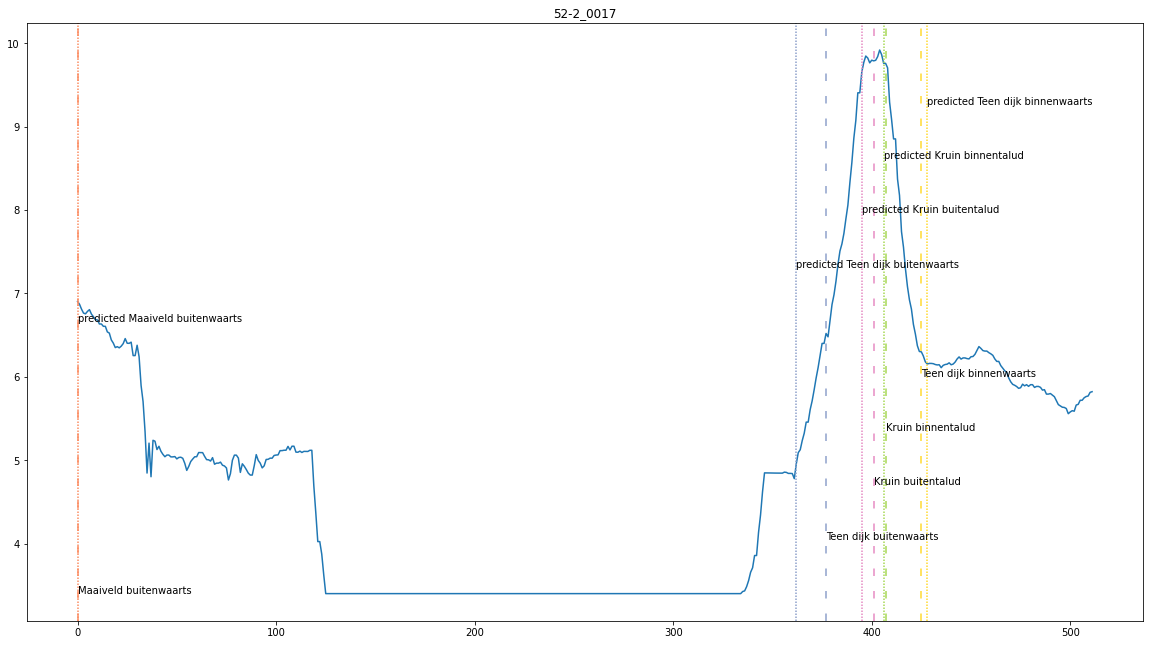

In [94]:
import dijkprofile_annotator.utils as utils
import dijkprofile_annotator.config as config
from dijkprofile_annotator import visualize_prediction

random_key = random.choice(list(profile_dict_holdout.keys()))
profile = profile_dict_holdout[random_key]

prediction = model(torch.FloatTensor(profile['profile']).reshape(1,1, max_profile_size).to(0))
prediction_iso = utils.force_sequential_predictions(prediction, method='isotonic')
prediction_first = utils.force_sequential_predictions(prediction, method='first')

visualize_prediction(profile['profile'], prediction, profile['label'], random_key, class_mapping)
visualize_prediction(profile['profile'], prediction_iso, profile['label'], random_key, class_mapping)
visualize_prediction(profile['profile'], prediction_first, profile['label'], random_key, class_mapping)

# training the scaler
You can pass a custom scaler to the training function, this is useful if your profiles are very different in scale than the profiles this model was trained on.

In [ ]:
from dijkprofile_annotator.preprocessing import make_height_profiles, read_surfaceline_file
from dijkprofile_annotator.utils import train_scaler
import joblib

surfacelines_files = [tup[0] for tup in pairs]

# load surfacelines
sl_dict = {}
for sl in surfacelines_files:
    sl_dict.update(read_surfaceline_file(sl))

# convert to height profiles
profile_dict = make_height_profiles(sl_dict, max_profile_size=352)

scaler = train_scaler(profile_dict)

scaler_path = "/home/parting/repositories/dijkprofile-annotator/output/models/scaler.pik"
joblib.dump(scaler, scaler_path)